# Residual Analysis

## 1. ML Model

In [82]:

import pandas as pd
from loguru import logger
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import optuna
import matplotlib.pyplot as plt
from blog.data.data_cleaner_factory import DataCleanerFactory
from blog.model.regularisation import select_features, get_monotone_constraints
from blog.model.optimise import ROCAUCObjective, MultiObjective, PRAUCObjective
from blog.model.evaluation import show_model_results
from probatus.interpret import ShapModelInterpreter
from blog.data.lendingclub_dataset import LendingClubDataset
from blog.model.sampling import oot_split
from blog.model.regularisation import get_monotone_constraints
from blog.model.feature_transformations import get_simple_feature_transformation
from blog.model.optimise import getObjective, tune_model

dataset_name = "lendingclub"
target = "loan_status"
path = "../data/lc_2007_2017_selected.csv"


initial_features = [
    "verification_status",
    "emp_title",
    "int_rate",
    "loan_amnt",
    "total_rec_int",
    "total_acc",
    "tot_cur_bal",
    "fico_range_low",
    "fico_range_high",
    "grade",
    "total_rev_hi_lim",
    "sub_grade",
    "initial_list_status",
    "purpose",
    "issue_d",
    "emp_length",
    "pub_rec_bankruptcies",
    "last_pymnt_amnt",
    "num_actv_bc_tl",
    "total_pymnt",
    "loan_status",
    "term",
    "home_ownership",
    "revol_util",
    "application_type",
    "addr_state",
    "inq_last_6mths",
    "pub_rec",
    "dti",
    "mort_acc",
    "revol_bal",
    "title",
    "annual_inc",
    "out_prncp",
    "open_acc",
]

# combine two lists without duplicates
initial_features = list(set(initial_features))
print(initial_features)
# ================== Read and clean the dataset.===========================================
logger.info(f"1.Read data")
lcd = LendingClubDataset()
X, y = lcd.get_data(path=path, use_cols=initial_features, dropna=True, sample=-1)
logger.info(f"\nTarget distribution:\n{y.value_counts(normalize=True)}")

# Split data into IT & OOT datasets.
data = X.copy()
data[target] = y

X_it, y_it, X_oot, y_oot = oot_split(
    df=data, split_date="Jun-2016", split_col="issue_d", target_col=target
)
# Original data dictionary
data_dict = {"xtrain": X_it, "ytrain": y_it, "xtest": X_oot, "ytest": y_oot}

# =================== Apply feature transformation =========================================
logger.info(f"2.Transform features")
#data_dict = get_simple_feature_transformation(data_dict_org)

# =================== Feature Selection =========================================
logger.info(f"3.Starting feature selection.")
# Select the best features based on SHAPRFE CV
# selected_features, fs_plot = select_features(data=data_dict, verbose=100)

selected_features = [
    "emp_length",
    # "addr_state",
    "revol_util",
    "revol_bal",
    "term",
    "num_actv_bc_tl",
    "total_acc",
    "application_type",
    "purpose",
    "grade",
    'dti'
]
logger.info(f"Final features :  {selected_features}")
# Update the data dictionary with the selected features.
data_dict["xtrain"] = data_dict["xtrain"][selected_features]
data_dict["xtest"] = data_dict["xtest"][selected_features]


# model_params = tune_model(data_dict["xtrain"], data_dict["ytrain"], "rocauc")

model_params = {
    "objective": "binary",
    "metric": "binary_logloss",
    "verbosity": -1,
    "boosting_type": "gbdt",
    "feature_pre_filter": False,
    "lambda_l1": 3.221919143923753e-08,
    "lambda_l2": 0.0016740960905730054,
    "num_leaves": 66,
    "feature_fraction": 0.6,
    "bagging_fraction": 1.0,
    "bagging_freq": 0,
    "min_child_samples": 20,
}


# =================== Train Model =========================================
logger.info(f"5.Train Model ")
logger.info(f"Creating model with params : {model_params}")
mono_lgb = lgb.LGBMClassifier(**model_params)
mono_model = show_model_results(data=data_dict, model=mono_lgb)

2022-04-11 12:04:56.547 | INFO     | __main__:<module>:65 - 1.Read data
2022-04-11 12:04:56.592 | INFO     | blog.data.lendingclub_dataset:_read_data:24 - Reading data from path ../data/lc_2007_2017.csv


['issue_d', 'verification_status', 'annual_inc', 'total_acc', 'fico_range_low', 'mort_acc', 'total_pymnt', 'tot_cur_bal', 'title', 'loan_status', 'last_pymnt_amnt', 'out_prncp', 'inq_last_6mths', 'int_rate', 'term', 'loan_amnt', 'sub_grade', 'addr_state', 'num_actv_bc_tl', 'emp_length', 'emp_title', 'revol_bal', 'purpose', 'pub_rec_bankruptcies', 'open_acc', 'application_type', 'home_ownership', 'pub_rec', 'dti', 'fico_range_high', 'initial_list_status', 'total_rec_int', 'grade', 'total_rev_hi_lim', 'revol_util']


2022-04-11 12:05:06.995 | INFO     | blog.data.lendingclub_dataset:_read_data:28 - Read data with shape (1646801, 35)
2022-04-11 12:05:09.273 | INFO     | blog.data.lendingclub_dataset:_process_data:72 - Creating target data.
2022-04-11 12:05:12.476 | INFO     | blog.data.lendingclub_dataset:get_data:115 - Shape of training data X :(682278, 34), y : (682278,).
2022-04-11 12:05:12.496 | INFO     | __main__:<module>:68 - 
Target distribution:
0    0.793679
1    0.206321
Name: loan_status, dtype: float64
2022-04-11 12:05:12.792 | INFO     | blog.model.sampling:oot_split:63 - IT data info 
 : {'name': 'IT', 'X_shape': (597837, 35), 'y_shape': (597837,), 'default_rate': 21.097389422200365, 'pct_of_data': 87.6, 'earliest_disbursed_date': Timestamp('2012-08-01 00:00:00'), 'latest_disbursed_date': Timestamp('2016-05-01 00:00:00'), 'default_count': 126128}
2022-04-11 12:05:12.793 | INFO     | blog.model.sampling:oot_split:64 - OOT data info 
 : {'name': 'OOT', 'X_shape': (84441, 35), 'y_shape':

[LightGBM] [Warning] lambda_l1 is set=3.221919143923753e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.221919143923753e-08
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=0.0016740960905730054, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0016740960905730054
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
Train ROC-AUC score : 0.7229743086833438
Test ROC-AUC score : 0.6738510017118924
Test PR AUC socre : 0.29193466693181097
Best balanced accouracy of 0.5265464132107647 obtained at threshold 0.01 


## Error Analysis

In [83]:
# Create a validation set, to do the error analysis.
X_train, X_val, y_train, y_val = train_test_split(data_dict["xtrain"], data_dict["ytrain"], test_size=0.2,stratify=data_dict["ytrain"])

In [84]:
# Train the model
lgb_model = lgb.LGBMClassifier(**model_params)
lgb_model.fit(X_train,y_train)

yhat_name = 'p_loan_status'
preds1 = lgb_model.predict_proba(X_val)[:,1]
X_val_results = X_val.copy().reset_index(drop=True)
X_val_results[yhat_name] = preds1
X_val_results[target] = y_val.values

X_val_results.head()

[LightGBM] [Warning] lambda_l1 is set=3.221919143923753e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.221919143923753e-08
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=0.0016740960905730054, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0016740960905730054
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


,emp_length,revol_util,revol_bal,term,num_actv_bc_tl,total_acc,application_type,purpose,grade,dti,p_loan_status,loan_status
0,6.0,71.0,10786.0,36 months,3.0,28.0,Individual,debt_consolidation,D,19.94,0.232845,0
1,1.0,53.0,5931.0,36 months,4.0,39.0,Individual,other,C,15.21,0.202370,0
2,10.0,86.1,5770.0,60 months,4.0,21.0,Individual,debt_consolidation,E,22.17,0.468987,1
3,4.0,23.9,3435.0,36 months,1.0,10.0,Individual,credit_card,C,16.51,0.205780,0
4,0.0,96.3,10590.0,36 months,2.0,17.0,Individual,debt_consolidation,C,32.71,0.256330,1


In [85]:
# Calculate the log loss error.
from sklearn.metrics import log_loss
import numpy as np
resid_name = f'r_{target}' 
# calculate logloss residuals
X_val_results[resid_name] = -X_val_results[target]*np.log(X_val_results[yhat_name]) -(1 - X_val_results[target])*np.log(1 - X_val_results[yhat_name])   
# check that logloss is calculated correctly
print('Mean logloss residual: %.6f' % X_val_results[resid_name].mean())
print('Logloss from sklearn %.6f' % log_loss(y_val, preds1))

Mean logloss residual: 0.466611
Logloss from sklearn 0.466611


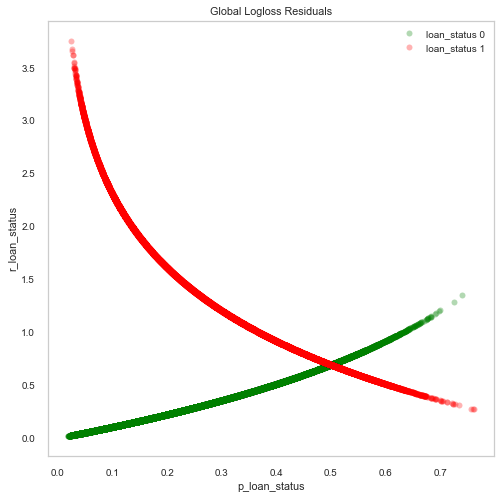

In [86]:
# initialize figure
# Matplotlib figure inline
%matplotlib inline   
fig, ax_ = plt.subplots(figsize=(8, 8))         
valid_yhat_df = X_val_results.copy()
# plot groups with appropriate color
color_list = ['green', 'red'] 
c_idx = 0
groups = valid_yhat_df.groupby(target) # define groups for levels of PAY_0
for name, group in groups:
    ax_.plot(group.p_loan_status, group.r_loan_status, 
             label=' '.join([target, str(name)]),
             marker='o', linestyle='', color=color_list[c_idx], alpha=0.3)
    c_idx += 1
    
# annotate plot
plt.xlabel(yhat_name)
plt.ylabel(resid_name)
ax_.legend(loc=1)
plt.title('Global Logloss Residuals')
plt.show()


Some high-magnitude outlying residuals are visible. 
* Who are these customers? 
* Why is the model so wrong about them? 
* And are they somehow exerting undue influence on other predictions? 

The model could be retrained without these individuals and retested as a potentially remediation strategy.

`loan_status = 1 Residuals`

In [87]:
bins = [0, 30, 90, 100]
labels = ['low','medium','high']
valid_yhat_df['dti_binned'] = pd.cut(valid_yhat_df['dti'], bins=bins, labels=labels)

valid_yhat_df1 = valid_yhat_df[valid_yhat_df[target] == 1]
valid_yhat_df1 = valid_yhat_df1.sort_values(by=f'r_{target}', ascending=False).reset_index(drop=True)
valid_yhat_df1.head()

,emp_length,revol_util,revol_bal,term,num_actv_bc_tl,total_acc,application_type,purpose,grade,dti,p_loan_status,loan_status,r_loan_status,dti_binned
0,0.0,10.0,8131.0,36 months,2.0,20.0,Individual,home_improvement,A,0.75,0.023371,1,3.756264,low
1,10.0,45.7,32703.0,36 months,2.0,16.0,Individual,credit_card,A,8.61,0.025223,1,3.680007,low
2,2.0,19.7,59380.0,36 months,2.0,27.0,Individual,debt_consolidation,A,8.25,0.025845,1,3.655627,low
3,10.0,13.3,11702.0,36 months,3.0,36.0,Individual,credit_card,A,11.87,0.026789,1,3.619769,low
4,5.0,3.2,19112.0,36 months,1.0,29.0,Individual,major_purchase,A,16.88,0.026844,1,3.617714,low


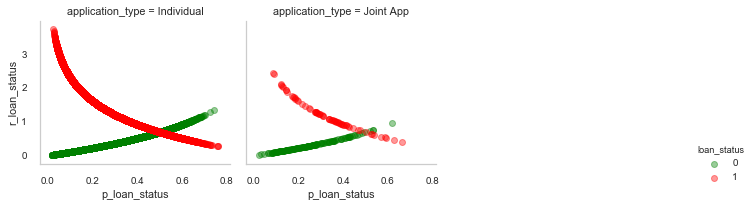

In [91]:
# use Seaborn FacetGrid for convenience
# some seaborn configs
import seaborn as sns
sns.set(font_scale=0.9)                                         # legible font size
sns.set_style('whitegrid', {'axes.grid': False})                # white background, no grid in plots
sns.set_palette(sns.color_palette(["green", "red"]))      # consistent colors

# facet grid of residuals by PAY_0 
sorted_ = valid_yhat_df.sort_values(by='application_type')                 # sort for better layout of by-groups
g = sns.FacetGrid(sorted_, col='application_type', hue=target, col_wrap=4) # init grid
_ = g.map(plt.scatter, yhat_name, resid_name, alpha=0.4)        # plot points
_ = g.add_legend(bbox_to_anchor=(0.82, 0.2))                    # legend